# Next Type - A Mobile Typing Assistant
[CS 505 - NLP] [Final Project]
Completed by Muhammad Aseef Imran
---

### Problem Statement

Compared to typing on a keyboard, typing on our phones considerably slower. Luckily most phones come built in with a feature to predict your next word to make up for this. However, after much experimentation, it seems most of these prediction algorithms seem to use simple N-grams with a window of around 3-4 words of left context. Many times, predicting the next word based on simple N-gram based probabilities work "fine" but often, this strategy produces poor results due to ignoring the context of the sentence. As NLP technology leaps forward exponentially we can do much better than simplistic N-grams. For this reason **Next Type** aims to bring the next generation of typing experiance to its users in order to raise productivity and typing speed for users leaving more time for the important things in life!

<div style="display: flex; justify-content: space-between;">
    <img src="assets/bad-phone-example-1.jpg" alt="N-gram example 1" style="width: 33%; padding-right: 10px;">
    <img src="assets/bad-phone-example-2.jpg" alt="N-gram example 2" style="width: 33%; padding-right: 10px;">
    <img src="assets/bad-phone-example-3.jpg" alt="N-gram example 3" style="width: 33%;">
</div>

Presented above are three examples where unfortunately, the standard N-gram model employed on "modern" devices fails miserably.
___

### Project Goals

N-gram models perform poorly with shorter context window, and any large context windows require an immense amount of data to produce reasonable results. Moreover, at least in this case, our N-gram models do not consider the right context when suggesting words. However, despite having their weaknesses, the N-gram approach also has some nice benefits. Particularly, the nature of the N-gram model allows it to be easily updated with new data and adapt to the typing habits of its users with little processing power.

Keeping these things in mind, we can when we set out on this project our (rather ambitious) goals for the model were:
1. The model should consider the left (and ideally also the right context) before suggesting a "natural" word that fits the context.
2. The model should be able to adapt to or learn from the user's word choices in various contexts.
3. The model should be able to learn the user's word choice as—outlined above—quick enough to be useful.
4. The model should be reasonably sized allowing it to be run and be updated on most modern-phone hardware with in reasonable time.

### Definition a "Successful" Prediction

We define a successful prediction as a prediction that meets the following criteria:
```The predicted next word is one of the top 5 predictions```

Also considered was to define a successful prediction if the predicted word as a similar meaning to the actual word. However, given the constraints this turned out to be a challenging task.

### Key Questions & Challenges

As we set out on this prototype application, I outlined a few guiding key questions for myself:

1. People evolve and change. So can I get a better accuracy by consider ALL known history? Or only "recent" history? Should the more recent history be weighted more"? If so, should history be judged more by time or the volume typed? If I'm wrong about this, then more data = better. OR the time people change in is just longer.

2. My problem is my data is ever evolving. So how do I prevent the model from overfitting? Overfitting will make newer data harder to generalize. (i.e. How do I prevent it from forgetting the stuff it knew in the base model?).

### Obtaining the Fine-Tuning Data

It is important for my task that the fine-tunning data only come from a single person since my goal is to train the model to adapt to the typing behavior of a specific user. In order to achieve this we can use scraped messages from reddit for specific users and examine how the model adapts to their specific word-choice and typing habits. Particularly, we will be using data from a pre-scrapped dataset [Reddit comments/submissions 2005-06](https://academictorrents.com/details/89d24ff9d5fbc1efcdaf9d7689d72b7548f699fc). Further, we also want to make sure that sample data from any user we use:
* Provides a reasonably large enough dataset to train on
* Posts regularly (as opposed to posting a lot occasionally)

With that defined, our focus will be between and including messages posted between [1/2011 - 6/2012]. Why this particular time range? No particular reason besides that data with in this time range was reasonably enough sized to be processed quickly yet still leave us with enough data to work with.

We can then process the reddit dump creating a dictionary consisting of reddit users and the messages they sent. We further filter this data as follows:
* "Deleted" users aren't included
* First, we remove all authors with less than 546 (i.e. they must average more than 1 post a day) - although future filteration steps would've already ensured this requirement, we start of with this since this is a quick and dirty elimination step allowing for quicker processing in the next steps (which are a bit more complicated implementation wise)
* Second, we filter to only authors that made at least 18 post per month in the time range without missing any month.
* Third, we filter to only authors that made at least 2 post every week without missing a week.
* Fourth, we filter down the remaining users to those that posted on at least 80% of the days.

Code for this is implemented in the [data_processing_util.py](./data_processing_util.py) script file.

Additional post-processing:
* In our final step, we post process the post messages by running it through a sequence-to-sequence model already developed by someone correcting silly grammatical errors. Otherwise, we may end up having messages in our data set that contain non-existent vocab. In many cases, this post-processing fundamentally changed the sentence. However, I considered this a necessary evil because otherwise

### Establishing a Baseline

As previously mentioned, we want to develop a model the beats the naive n-gram models (with a window of 3) used by most keyboard apps. Therefore, we will define our baseline as 3-gram model trained on the entire reddit corpus. A larger window size will not be feasible do to the massive amounts of memory required to hold such a model. This model uses simple probabilities based on the frequency of the n-gram in the corpus to make predictions.

However, compared to n-gram models used by most keyboard apps, we will be making several simplification assumptions for our baseline:
1. Our baseline model will not "update" n-gram model by using data from its user. On real keyboard apps, the model updates based on the users behavior (much like how we will update our models too later in this project). However, just for the purpose of having a working "baseline" and in the interest of time, this is a detail we neglect.
2. Our model will also predict punctuations. Most keyboard apps only predict words however to get a fairer comparison to the models we will me employing (which do predict) punctuations, our version predicts punctuations (or tries to anyways).
3. As previously implied, our n-gram model will be constructed solely of reddit. Specifically, the n-gram model is "trained" on all messages typed on reddit between [1/2011 - 6/2012].

#### Baseline Training Details

We will be training a 3-gram model and a 2-gram model. Our model will first attempt to use the 3-gram to make a prediction. If the 3-gram model does not have a machine n-gram, we will then fall back to 2-grams.

The 3-gram model is trained as follows:
1. For each month in the range [1/2011 - 6/2012], gather all posts and for each posts construct a 3-gram.
    1. Add the 3-grams to a counter.
    2. If by the time we finish processing the current month, if n-gram has not occurred at least 2 times delete it.
2. Now for the entire n-gram dictionary, delete all n-gram that occurred less than 16 times in the entire corpus.

Similarly, for the 2-gram model:
1. For each month in the range [1/2011 - 6/2012], gather all posts and for each posts construct a 2-gram.
    1. Add the 2-grams to a counter.
    2. If by the time we finish processing the current month, if n-gram has not occurred at least 5 times delete it.
2. Now for the entire n-gram dictionary, delete all n-gram that occurred less than 25 times in the entire corpus.

Exact training script used can be found in the [create_raw_reddit_ngrams.py](./create_raw_reddit_ngrams.py) file.

### Evaluation Stategy

In light of our above outlined goals, we have two major evaluation goals:


1. How well does the model predict the user's next token after having seen x tokens of examples from the user. In other words, not only how well the model predicts the user's next token but also how fast the model improves its prediction as a function of the data it has already seen?

> We can evaluate "how well" the model predicts the user's next token by measuring the loss between what the user actually types vs what the model suggests. Then, we can further measure this loss as function of the number of tokens of examples the model has seen during its Fine-Tuning. For example, how does the loss change after the model has seen 1000 tokens of examples from the user?

2. How much computation is needed is to both run the model and update the model on new data?

> Measuring how long various parts of the model such prediction and training takes is trivial. (We can simply calculate the time between the target area of code). We may then analyze the run-time in context of the hardware the code is run on and comparing this information with current state of computational power of modern mobile devices. This information can be used to make an informed decision on the sequence lengths to input to the model to ensure our model can suggest new words to users in real-time on standard mobile hardware.

### Project Plan and Exploring Potential Solutions

Once again, our goal is to accuractely and effectively predict the user's next token in real-time while adapting to the user's behavior and writing style over time.

In order to reasonably meet these goals, we will fine-tune one or more combination of existing models such as T5, Bert, and GPT2, and/or their "Distilled" counterparts. We will use the Hugging Face transformers library simply due to its vast popularity and easy of use. I intend to use the SCC for rapid prototyping and experimentation as I already have significant experiance using the SCC at this stage.

Finally I should note that in my initial research, I have identified potential pitfalls with each of these models and their strengths and weaknesses for my task. However, further experimentation will be needed to make a final decision on which model (or model combinations) to use. Detailed experimentation with each model will be required to evaluate its pros/cons.

#### DistilBert [267MB]
Having been trained on a mask-fill task, Bert naturally lends itself to the kind of project I am trying to do. Being a relatively small model, and still quite versatile for the task, Bert may be a great choice. However, one downside to Bert is that Bert seems to perform poorly when attempting to Mask-Fill multiple words in the middle of a sentence. (See the bottom of this notebook for a demonstration).

#### DistilGPT2 [352MB]
GPT2 was essentially trained on predicting the next word. Indeed, this is the task we want to achieve ourselves. However, in some cases, we may need to predict the middle word (if someone is editing the middle of a sentence they wrote). This is not a task GPT2 was designed for although this may still be possible due to the surprising generality of the model. Further research and experimentation will be needed.

#### T5-Small [242 MB]
T5 is an extremely general purpose model than can adapt to many NLP tasks. Unlike bert Being a substantially larger model than both GPT2 and Bert, T5 is slower to retrain. Yet at the same time, T5 seems to do a much better job mask-filling between sentences. Yet, in a realistic scenario how often does one write in the middle of the sentence? Is the increased computing cost really worth it? These are the questions I hope to answer with the first stages of my research.

### Limitations
* Compared to the N-gram approach, this new model cannot easily learn new words?
* You may talk different with friends vs family vs boss. This training and results was done specifically for reddit. It may be the case that the model will not generalize as well to a broader domain in an actual key board app. (Still probability at least better than the ngram stuff right?)

### Comparison and Exploratory Between Various Models

We begin with an exploratory between different promising transformer models that have been historically very successful with a variety of tasks. Namely, we will do a comparisons between Bert, GPT2, and T5 on various tasks.

1. We compare between the following 5 sentences to see how well the models do. These results are just to get a basic idea of each model's capabilities. We will "eyeball this result". Note that the "|" token represents the current "cursor" location.

    a. `After forcefully breaking into the bank, they|`

    b. `Every |, my family and I visit Hawaii.`

    c. `In my family, there is my |`

    d. `My favorite | is apple.`

    e. `It has been 2 months since I graduated. However, unfortunately I still haven't found a |. At this rate I won't be able to pay rent!`

2. After that, we will test each model to see how well the model does in predicting this "next" word token. This task is the most important task for our proposed application to do well.

3. Finally, we will choose the most promising model to develop a fine-tuning method for this continuous learning project.

#### Setup: Imports

In [1]:
# all imports here
from typing import Union
import os
import pickle
import gzip
import torch
from tqdm import tqdm
from typing import Dict, Tuple, List, Set, Any, Union
import statistics
import random
import re
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
import nltk
import time
from collections import Counter

from transformers import GPT2LMHeadModel, GPT2Tokenizer, PreTrainedTokenizerBase, PreTrainedModel, GPT2Config
from transformers import pipeline
from transformers import DistilBertForMaskedLM, DistilBertTokenizer, DistilBertConfig, AdamW
from torch.utils.data import DataLoader, TensorDataset
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from datasets import Dataset
from datasets.utils.logging import disable_progress_bar, enable_progress_bar
from datasets import load_dataset, load_from_disk
from transformers import TextDataset, DataCollatorForLanguageModeling, TrainingArguments, Trainer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /usr4/cs505ws/aseef/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
test_sentences = [
    "After forcefully breaking into the bank, they |", # predict the next word using context
    "In my family, there is my |", # predict the next word using context
    "Every |, my family and I visit Hawaii.",  # simple mask fill with one missing word
    "My favorite | is apple.", # simple mask fill with one missing word
    "It has been 2 months since I graduated. However, unfortunately I still haven't found a | rate I won't be able to pay rent!", # need multiple words here before sentence makes sense
    "Following the American Civil War, | assassinated.",  # need multiple words here before sentence makes sense
]

In [3]:
data_dir = "/projectnb/cs505ws/projects/NextType/data"

def does_var_exists_gz(var_name: str) -> bool:
    return os.path.isfile(F'{data_dir}/{var_name}.pkl.gz')

def dump_var_gz(var_name: str, obj) -> None:
    os.makedirs(f"{data_dir}", exist_ok=True)
    with gzip.open(F'{data_dir}/{var_name}.pkl.gz', 'wb', compresslevel=1) as file:
        pickle.dump(obj, file)


def load_var_gz(var_name: str) -> Union[None, object]:
    if not does_var_exists_gz(var_name):
        return None

    file_path = F'{data_dir}/{var_name}.pkl.gz'  # Updated file extension
    with gzip.open(file_path, 'rb', compresslevel=1) as file:
        return pickle.load(file)

In [4]:
# load n_gram models
reddit_2_grams_pmf: Dict[Tuple[str, str], Dict[str, float]] = load_var_gz("reddit_2_grams_pmf")
reddit_3_grams_pmf: Dict[Tuple[str, str], Dict[str, float]] = load_var_gz("reddit_3_grams_pmf")

In [5]:
# load author to lines data
author_to_posts_dict: Dict[str, Tuple[int, str]] = load_var_gz("author_to_lines")

In [6]:
random_user_sample = random.sample(list(author_to_posts_dict.keys()), 25)
random_user_sample

['ThePain',
 'GoatseMcShitbungle',
 'Mike81890',
 'aerynmoo',
 'zoomshoes',
 'General_Mayhem',
 'kingmanic',
 'triliana',
 'smilingarmpits',
 'elitexero',
 'xyqxyq',
 'yoda133113',
 'skootles',
 'swordgeek',
 'aardvarkious',
 'darkshaddow42',
 'schlitz100',
 'NukeThePope',
 'ryeguy',
 'ten_thousand_puppies',
 'ObeseSnake',
 'prostidude',
 'gsfgf',
 'arlanTLDR',
 'amus']

In [7]:
# sample up to 50 posts from each user
random_post_samples = []
for rand_user in random_user_sample:
    all_posts = author_to_posts_dict[rand_user]
    sampled_posts = random.sample(list(all_posts), 50)
    random_post_samples += sampled_posts

In [8]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device={device}")

Using device=cuda


#### Data Cleaning

In [9]:
import html
def normalize_text(post_text: str):
    # get rid of new lines
    post_text = re.sub("\n", " ", post_text)
    # remove html characters
    post_text = html.unescape(post_text)
    # Remove bold and italic formatting
    post_text = post_text.replace('*', "")
    # Remove headers
    post_text = re.sub(r'^#{1,6}\s', '', post_text)
    # Remove hyperlinks
    post_text = re.sub(r'\[([^\]]+)\]\(([^)]+)\)', r'\1', post_text)
    # Remove inline code
    post_text = re.sub(r'`([^`]+)`', r'\1', post_text)
    # Remove block code
    post_text = re.sub(r'```[^`]*```', '', post_text)
    # Remove lists (unordered and ordered)
    post_text = re.sub(r'^\s*([\*\-\+]\s|(\d+\.)\s)', '', post_text)
    post_text = re.sub("(\*\*|__)(.*?)\1|(\*|_)(.*?)\3", "", post_text)
    # remove double spaces
    post_text = re.sub(" {2,}", " ", post_text)
    # replace urls
    post_text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "{URL}", post_text)
    # replace references to a specific subreddit but just the token "{SUB_REDDIT}"
    post_text = re.sub(r"(\W)(r/[a-z0-9A-Z_]{2,10})(\W)", r"\1{SUB_REDDIT}\3", post_text)
    post_text = re.sub(r"(\W)(/[a-z0-9A-Z_]{2,10})(\W)", r"\1{SUB_REDDIT}\3", post_text)
    post_text = post_text.strip()
    return post_text

#### Baseline (n-grams)

In [51]:
def get_ngram_prediction(current_sent) -> Union[None, str]:
    def tokenize_post(pre_tokenized_post_data):
        return [word for sent in nltk.sent_tokenize(pre_tokenized_post_data) for word in nltk.word_tokenize(sent)]

    current_sent = normalize_text(current_sent)
    current_sent = current_sent.lower()
    ngram_input = tokenize_post(current_sent)

    if tuple(ngram_input[-2:]) in reddit_3_grams_pmf:
        prediction = reddit_3_grams_pmf[tuple(ngram_input[-2:])]
    elif tuple(ngram_input[-1:]) in reddit_2_grams_pmf:
        prediction = reddit_2_grams_pmf[tuple(ngram_input[-1:])]
    else:
        prediction = None

    return prediction

##### Baseline n-grams On the Sample Sentences

In [46]:
for sentence in test_sentences:
    # out ngram model can only consider left context
    input_text = sentence[:sentence.index("|")].strip()
    suggestions = get_ngram_prediction(input_text)

    print('Sentence:', sentence)
    print('Suggestions:', suggestions)
    print("-=+=--=+=--=+=--=+=--=+=-")

Sentence: After forcefully breaking into the bank, they |
Suggestions: {'are': 0.3346073933449349, "'re": 0.30994814463253, 'do': 0.12743342298159574, 'have': 0.12373499270509238, 'will': 0.104276046335847}
-=+=--=+=--=+=--=+=--=+=-
Sentence: In my family, there is my |
Suggestions: {'favorite': 0.5853830605651704, 'first': 0.1888119327439376, 'favourite': 0.0983645108370054, 'new': 0.06445652599929452, 'opinion': 0.06298396985459208}
-=+=--=+=--=+=--=+=--=+=-
Sentence: Every |, my family and I visit Hawaii.
Suggestions: {'time': 0.3896827529049508, 'day': 0.23419787074369317, 'single': 0.18737812391879125, 'other': 0.1147109820572633, 'year': 0.0740302703753015}
-=+=--=+=--=+=--=+=--=+=-
Sentence: My favorite | is apple.
Suggestions: {'.': 0.33868374032162, 'part': 0.25645473496128646, 'is': 0.17503722453841572, ',': 0.12518612269207863, 'thing': 0.10463817748659916}
-=+=--=+=--=+=--=+=--=+=-
Sentence: It has been 2 months since I graduated. However, unfortunately I still haven't foun

##### Baseline n-grams on "Predict the Next Token"

In [53]:
baseline_correct_guesses = 0
baseline_total_guesses = 0
baseline_inference_times = []

for creation, post in tqdm(random_post_samples, smoothing=0):
    sent_tokenized = sent_tokenize(normalize_text(post))
    tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
    tokenized_words = [word for s in tokenized_words for word in s]

    for i in range(1, len(tokenized_words) - 1):
        start_time = time.time()
        current_prompt = ' '.join(tokenized_words[:i])
        current_prompt = re.sub(r" ([!.?,;:\"')\]}]{1,9})", r"\1", current_prompt)
        current_prompt = re.sub(r"([\[({]{1,9}) ", r"\1", current_prompt)
        actual_next_word = tokenized_words[i]

        predictions = get_ngram_prediction(current_prompt)
        if predictions is not None and actual_next_word in predictions:
            baseline_correct_guesses += 1
        baseline_total_guesses += 1

        baseline_inference_times += [time.time() - start_time]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:29<00:00, 41.95it/s]


In [54]:
baseline_accuracy = baseline_correct_guesses / baseline_total_guesses
print(baseline_accuracy)

0.38662746585735963


In [17]:
print('Avg Inference Time:', statistics.mean(baseline_inference_times))
print('Inference Std:', statistics.stdev(baseline_inference_times))

Avg Inference Time: 0.022976395781948235
Inference Std: 0.00535418975672332


#### T5-Small

In [45]:
# load in the t5 model
T5_path = 't5-small'
t5_config = T5Config.from_pretrained(T5_path)
t5_tokenizer = T5Tokenizer.from_pretrained(T5_path, legacy=False)
t5_model = T5ForConditionalGeneration.from_pretrained(T5_path, config=t5_config).to(device)
t5_model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

##### T5-Small On the Sample Sentences

In [46]:
for sentence in test_sentences:

    input_text = sentence.replace("|", "<extra_id_0>")
    input_ids = t5_tokenizer(input_text, return_tensors="pt").to(device).input_ids

    # Generate predictions for the next token
    num_samples = 5
    with torch.no_grad():
        output = t5_model.generate(
            input_ids,
            num_beams=num_samples,
            min_new_tokens=2,
            max_new_tokens=2,
            num_return_sequences=num_samples,  # Generate multiple suggestions
            return_dict_in_generate=True,
            output_scores=True)

    probabilities = torch.nn.functional.softmax(output.sequences_scores, dim=-1)

    # Decode and print the predicted token
    suggestions = []
    for sample_output, prob in zip(output.sequences, probabilities):
        decoded_output = t5_tokenizer.decode(sample_output, skip_special_tokens=False)
        suggestions += [(decoded_output, prob.item())]
    print('Sentence:', sentence)
    print('Suggestions:', suggestions)
    print("-=+=--=+=--=+=--=+=--=+=-")

Sentence: After forcefully breaking into the bank, they |
Suggestions: [('<pad> <extra_id_0> broke', 0.22146426141262054), ('<pad> <extra_id_0> break', 0.21711385250091553), ('<pad> <extra_id_0> are', 0.21013765037059784), ('<pad> <extra_id_0> were', 0.17779791355133057), ('<pad> <extra_id_0> will', 0.1734863519668579)]
-=+=--=+=--=+=--=+=--=+=-
Sentence: In my family, there is my |
Suggestions: [('<pad> <extra_id_0> family', 0.27247941493988037), ('<pad> <extra_id_0> own', 0.25976160168647766), ('<pad> <extra_id_0> daughter', 0.15796756744384766), ('<pad> <extra_id_0> mother', 0.1555204540491104), ('<pad> <extra_id_0> home', 0.1542709767818451)]
-=+=--=+=--=+=--=+=--=+=-
Sentence: Every |, my family and I visit Hawaii.
Suggestions: [('<pad> <extra_id_0> year', 0.3100126087665558), ('<pad> <extra_id_0> day', 0.2699778378009796), ('<pad> <extra_id_0> month', 0.1532614529132843), ('<pad> <extra_id_0> week', 0.14059576392173767), ('<pad> <extra_id_0> time', 0.12615235149860382)]
-=+=--=+=

##### T5-Small on "Predict the Next Token"

In [ ]:
t5_correct_guesses = 0
t5_total_guesses = 0
t5_inference_times = []

for creation, post in tqdm(random_post_samples, smoothing=0):
    sent_tokenized = sent_tokenize(normalize_text(post))
    tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
    tokenized_words = [word for s in tokenized_words for word in s]
    for i in range(1, len(tokenized_words) - 1):
        start_time = time.time()
        current_prompt = ' '.join(tokenized_words[:i]) + " <extra_id_0>"
        current_prompt = re.sub(r" ([!.?,;:\"')\]}]{1,9})", r"\1", current_prompt)
        current_prompt = re.sub(r"([\[({]{1,9}) ", r"\1", current_prompt)
        actual_next_word = tokenized_words[i]
        input_ids = t5_tokenizer(current_prompt, return_tensors="pt").to(device).input_ids
        # t5 can only accept up to 512 tokens so if our tensor is bigger than this
        # we trim it before passing into the model
        if input_ids[0].shape[0] > 512:
            input_ids = input_ids[:, -512:]

        with torch.no_grad():
            # generate one word at a time
            num_samples = 7
            output = t5_model.generate(
                input_ids,
                num_beams=num_samples,
                min_new_tokens=2,
                max_new_tokens=2,
                num_return_sequences=num_samples,  # Generate multiple suggestions
                return_dict_in_generate=True,
                output_scores=True
            )

        probabilities = torch.nn.functional.softmax(output.sequences_scores, dim=-1)

        # Decode and print the predicted token
        suggestions = set()
        for sample_output, prob in zip(output.sequences, probabilities):
            if len(suggestions) >= 5:
                break
            decoded_output = t5_tokenizer.decode(sample_output, skip_special_tokens=True)
            if decoded_output.strip() == '':
                continue
            suggestions.add(decoded_output)

        if actual_next_word in suggestions:
            t5_correct_guesses += 1
        t5_total_guesses += 1
        t5_inference_times += [time.time() - start_time]


 19%|██████████████████████▏                                                                                                | 233/1250 [03:49<16:41,  1.02it/s]

In [59]:
t5_accuracy = t5_correct_guesses / t5_total_guesses
print(t5_accuracy)

0.37467754172989376


In [60]:
print('Avg Inference Time:', statistics.mean(t5_inference_times))
print('Inference Std:', statistics.stdev(t5_inference_times))

Avg Inference Time: 0.02229035642783812
Inference Std: 0.0007565512458901443


---
#### DistilBert

In [12]:
distbert_path = 'distilbert-base-cased'
distbert_model = DistilBertForMaskedLM.from_pretrained(distbert_path).to(device=device)
distbert_config = DistilBertConfig.from_pretrained(distbert_path)
distbert_tokenizer = DistilBertTokenizer.from_pretrained(distbert_path, config=distbert_config)

##### DistilBert On the Sample Sentences

In [20]:
for sentence in test_sentences:

    input_text = sentence.replace("|", "[MASK]")
    input_ids = distbert_tokenizer(input_text, return_tensors="pt").to(device).input_ids

    # Get the position of the masked token
    mask_token_index = torch.where(input_ids == distbert_tokenizer.mask_token_id)[1].tolist()[0]

    # Generate predictions for the next token
    with torch.no_grad():
        output = distbert_model(input_ids)
        predictions = output.logits

    # Get the top-k predicted tokens and their probabilities
    top_k = 5  # Adjust as needed
    probs, indices = torch.topk(predictions[0, mask_token_index], k=top_k, dim=-1)

    # Convert indices back to tokens
    predicted_tokens = distbert_tokenizer.convert_ids_to_tokens(indices.tolist())

    # Decode and print the predicted token
    suggestions = []
    for sample_output, prob in zip(predicted_tokens, probs.tolist()):
        suggestions += [(sample_output, prob)]
    print('Sentence:', sentence)
    print('Suggestions:', suggestions)
    print("-=+=--=+=--=+=--=+=--=+=-")

Sentence: After forcefully breaking into the bank, they |
Suggestions: [('!', 7.7542314529418945), ('.', 7.455650806427002), ('escape', 6.470279693603516), (':', 6.367412567138672), ('find', 6.3458967208862305)]
-=+=--=+=--=+=--=+=--=+=-
Sentence: In my family, there is my |
Suggestions: [('heart', 6.815902233123779), ('destiny', 6.189598560333252), ('.', 6.164964199066162), ('love', 6.162736415863037), ('family', 6.145949363708496)]
-=+=--=+=--=+=--=+=--=+=-
Sentence: Every |, my family and I visit Hawaii.
Suggestions: [('##day', 6.442167282104492), ('day', 5.875978946685791), ('morning', 5.826064586639404), ('##night', 5.271539688110352), ('night', 5.13131046295166)]
-=+=--=+=--=+=--=+=--=+=-
Sentence: My favorite | is apple.
Suggestions: [('fruit', 11.054349899291992), ('apple', 10.834712028503418), ('tree', 10.448899269104004), ('grape', 8.978232383728027), ('vegetable', 8.545177459716797)]
-=+=--=+=--=+=--=+=--=+=-
Sentence: It has been 2 months since I graduated. However, unfortu

##### DistilBert on "Predict the Next Token"

In [36]:
distbert_correct_guesses = 0
distbert_total_guesses = 0
distbert_inference_times = []

for creation, post in tqdm(random_post_samples, smoothing=0):

    sent_tokenized = sent_tokenize(normalize_text(post))
    tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
    tokenized_words = [word for s in tokenized_words for word in s]
    for i in range(1, len(tokenized_words) - 1):
        start_time = time.time()
        current_prompt = ' '.join(tokenized_words[:i]) + " [MASK]"
        current_prompt = re.sub(r" ([!.?,;:\"')\]}]{1,9})", r"\1", current_prompt)
        current_prompt = re.sub(r"([\[({]{1,9}) ", r"\1", current_prompt)
        actual_next_word = tokenized_words[i]
        input_ids: torch.Tensor = distbert_tokenizer(current_prompt, return_tensors="pt").to(device).input_ids
        # bert can only accept up to 512 tokens so if our tensor is bigger than this
        # we trim it before passing into the model
        if input_ids[0].shape[0] > 512:
            input_ids = input_ids[:, -512:]
        # Get the position of the masked token
        mask_token_index = torch.where(input_ids == distbert_tokenizer.mask_token_id)[1].tolist()[0]

        with torch.no_grad():
            # generate one word at a time
            output = distbert_model(input_ids)
            predictions = output.logits

        # Get the top-k predicted tokens and their probabilities
        top_k = 8  # Adjust as needed
        probs, indices = torch.topk(predictions[0, mask_token_index], k=top_k, dim=-1)

        # Convert indices back to tokens
        predicted_tokens = distbert_tokenizer.convert_ids_to_tokens(indices.tolist())

        # Decode and print the predicted token
        suggestions = set()
        for decoded_output, prob in zip(predicted_tokens, probs.tolist()):
            if len(suggestions) >= 5:
                break
            if prob < 0.04:
                # avoid bizarre suggestions by simply filtering out low prob
                # terms. We don't HAVE TO suggest exactly 5 words
                break
            # bert also suggests "sub-words". Ehh... we'll just ignore those.
            # otherwise stuff will get too complicated
            if decoded_output.startswith("##"):
                continue
            if decoded_output.strip() == '':
                continue
            suggestions.add(decoded_output)

        if actual_next_word in suggestions:
            distbert_correct_guesses += 1
        # since the way the bert tokenizer works, it can suggest "sub-words" - example: characteristically = characteristic + ##ally,
        # so we will give bert half a point for suggest the same start of the word
        for s in suggestions:
            if actual_next_word.startswith(s):
                distbert_correct_guesses += 0.5
                break
        distbert_total_guesses += 1
        distbert_inference_times += [time.time() - start_time]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [04:14<00:00,  4.90it/s]


In [37]:
bert_accuracy = distbert_correct_guesses / distbert_total_guesses
print(bert_accuracy)

0.18298021889747967


In [38]:
print('Avg Inference Time:', statistics.mean(distbert_inference_times))
print('Inference Std:', statistics.stdev(distbert_inference_times))

Avg Inference Time: 0.005107757104114663
Inference Std: 0.001992808943326104


#### Distil-GPT2

In [92]:
# Choose the GPT-2 model variant
distgpt2_model_name = "distilgpt2"

# Load pre-trained GPT-2 model and tokenizer
distgpt2_model: GPT2LMHeadModel = GPT2LMHeadModel.from_pretrained(distgpt2_model_name)
distgpt2_tokenizer: PreTrainedTokenizerBase = GPT2Tokenizer.from_pretrained(distgpt2_model_name)
# Move the model to the GPU (if available)
distgpt2_model = distgpt2_model.to(device)

In [13]:
for sentence in test_sentences:
    # delete everything including and after |
    # GPT2 is physically unable to consider right context
    input_text = sentence[:sentence.index("|")].strip()
    # Tokenize the prompt
    input_ids = distgpt2_tokenizer.encode(input_text, return_tensors="pt").to(device)
    # Generate probabilities for the next words
    with torch.no_grad():
        outputs = distgpt2_model(input_ids)
        logits = outputs.logits
    # we are only interested in either the top 5 words or words with a probability of > 1%
    # after all, we don't want to suggest too many words!
    top_k = 5
    # Get the probability distribution for the next word
    next_word_probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
    top_k_values, top_k_indices = torch.topk(next_word_probs, k=top_k, dim=-1)
    # Normalize probabilities
    top_k_probs_normalized = top_k_values / top_k_values.sum()

    # Convert the probabilities to a list
    top_k_probs_list: List = top_k_probs_normalized.tolist()[0]
    top_k_indices_list: List = top_k_indices.tolist()[0]

    # Decode and print the predicted token
    suggestions = []
    for sample_output, prob in zip(top_k_indices_list, top_k_probs_list):
        decoded_output = distgpt2_tokenizer.decode(sample_output)
        suggestions += [(decoded_output, prob)]
    print('Sentence:', sentence)
    print('Suggestions:', suggestions)

Sentence: After forcefully breaking into the bank, they |
Suggestions: [(' were', 0.6859785914421082), (' found', 0.10938050597906113), (' had', 0.08820205926895142), (' took', 0.059164125472307205), (' began', 0.05727475509047508)]
Sentence: In my family, there is my |
Suggestions: [(' family', 0.27839019894599915), (' brother', 0.2245674729347229), (' mother', 0.18426108360290527), (' sister', 0.1591966301202774), (' wife', 0.1535845696926117)]
Sentence: Every |, my family and I visit Hawaii.
Suggestions: [(' The', 0.40960025787353516), ('.', 0.16524524986743927), (' A', 0.15191836655139923), ('\n', 0.13858996331691742), ('The', 0.13464611768722534)]
Sentence: My favorite | is apple.
Suggestions: [(' favorite', 0.44314318895339966), (' part', 0.18813173472881317), (' thing', 0.16900213062763214), (' of', 0.11418430507183075), ('.', 0.08553868532180786)]
Sentence: It has been 2 months since I graduated. However, unfortunately I still haven't found a | rate I won't be able to pay rent!

In [14]:
distilgpt2_correct_predictions = 0
distilgpt2_total_predictions = 0
distilgpt2_inference_times = []

for creation, post in tqdm(random_post_samples, smoothing=0):
    sent_tokenized = sent_tokenize(normalize_text(post))
    tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
    tokenized_words = [word for s in tokenized_words for word in s]
    for i in range(1, len(tokenized_words) - 1):
        start_time = time.time()
        current_prompt = ' '.join(tokenized_words[:i])
        current_prompt = re.sub(r" ([!.?,;:\"')\]}]{1,9})", r"\1", current_prompt)
        current_prompt = re.sub(r"([\[({]{1,9}) ", r"\1", current_prompt)
        actual_next_word = tokenized_words[i]
        # Tokenize the prompt
        input_ids = distgpt2_tokenizer.encode(current_prompt, return_tensors="pt").to(device)
        if input_ids.shape[1] == 0:
            continue
        # gpt2 can only accept up to 1024 tokens so if our tensor is bigger than this
        # we trim it before passing into the model
        if input_ids[0].shape[0] > 1024:
            input_ids = input_ids[:, -1024:]
        # Generate probabilities for the next words
        with torch.no_grad():
            outputs = distgpt2_model(input_ids)
            logits = outputs.logits
        # we are only interested in either the top 5 words or words with a probability of > 1%
        # after all, we don't want to suggest too many words!
        top_k = 5
        top_p = 0.04  # don't suggest 5 words just for the sake of suggesting 5 words
        # Get the probability distribution for the next word
        next_word_probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        top_k_values, top_k_indices = torch.topk(next_word_probs, k=top_k, dim=-1)
        # Normalize probabilities
        top_k_probs_normalized = top_k_values / top_k_values.sum()

        # Convert the probabilities to a list
        top_k_probs_list: List = top_k_probs_normalized.tolist()[0]
        top_k_indices_list: List = top_k_indices.tolist()[0]

        # filter to only words with a probability greater than p%
        removal_marked = []
        for j in range(len(top_k_probs_list)):
            if top_k_probs_list[j] < top_p:
                removal_marked += [(top_k_probs_list[j], top_k_indices_list[j])]

        for to_remove in removal_marked:
            top_k_probs_list.remove(to_remove[0])
            top_k_indices_list.remove(to_remove[1])

        guesses = set()
        for token_id, prob in zip(top_k_indices_list, top_k_probs_list):
            token = distgpt2_tokenizer.decode([token_id])
            guesses.add(token)

        # we consider a prediction correct if the actual word was
        # one of the (up to) 5 words suggested
        if ' ' + actual_next_word in guesses:
            distilgpt2_correct_predictions += 1
        distilgpt2_total_predictions += 1
        distilgpt2_inference_times += [time.time() - start_time]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [04:22<00:00,  4.77it/s]


In [15]:
gpt2_accuracy = distilgpt2_correct_predictions / distilgpt2_total_predictions
print(gpt2_accuracy)

0.36095087922396757


In [16]:
print('Avg Inference Time:', statistics.mean(distilgpt2_inference_times))
print('Inference Std:', statistics.stdev(distilgpt2_inference_times))

Avg Inference Time: 0.0052210369432941625
Inference Std: 0.002328083751368582


### Summary of the results from Model Comparison

With a 38.6% accuracy, on top of having the fastest inference speeds, none of the models beat the baseline n-gram model. I was surprised by this result. All 3 transformer models had much larger context windows to work of from and understand language much better than n-grams, yet none beat n-grams on the random sample used.

In 2nd place was T5-small with an accuracy of 37.5%.
In 3rd place was DistilGPT2 with an accuracy of 36.1%.
And in 4th place was DistilBert with an accuracy of 18.2%.

The fact T5 beat DistilGPT2 was another shock. Despite being trained on the "predict the next word" task and being a larger model in raw size than T5-small, DistilGPT2 still lost. In fact T5-small is the smallest model here!

Let's now look at the runtimes of all 3 models on both GPU and CPU

* T5 was the slowest model
GPU
* 24:39 - T5-Small
* 5:10 - DistilBert
* 5:32 - DistilGPT2
CPU
* 3:19:43: T5-Small
* 1:41:39 - DistilBert
* 2:29:33 - DistilGPT2

Based on these results, I have decided to **use GPT2 for further fine-tuning** to see if we can beat the baseline for the following reasons:
* GPT2 is much faster than T5 on a GPU and considerably faster on a CPU. On an actual mobile device, using GPT2 allows me to reach a user-base with lower end CPUs as well. In other words, T5 is simply to slow to test and run!
* Due to T5's dexterity, initial research suggests fine-tuning T5 will be a much more complicated task than fine-tuning GPT2 for a "predict the next word task". After all, "predict the next word" is not the primary thing T5 was trained for. As a result, not as many resources exist either on achieving this.
* DistilGPT2 is the largest model here, and as such the extra parameters may allow it to adapt to our domain better.

#### Experimenting with Fine-Tuning GPT2
In this section, we Fine-tune GPT2 using data from a randomly select reddit user and then examining how GPT2 performs on an evaluation set from that user. This section is simply an experiment to see how well GPT2 might be able to adapt to the writing styles from a specific user.

This section differs from a real-word use case because in the real world, you will not have all the data from the user in once place to train on. Rather, in the real-word, we would continuously be updating an existing model as new data comes in. Continuous learning is instead something we explore in the next section.

In [10]:
# randomly select a user to train with
random_user = random.choice(list(author_to_posts_dict.keys()))
random_user

'The_Jackal'

In [11]:
# this was the only small-ish grammar correction model I found.
# had I more time, I would create my own model. But I don't so I will focus
# on my primary task.
# the downsides of this models is that besides correcting spellings, it often alters the
# structure of the sentence which could fundamentally undermine our purpose.
# so question: does benefits of correcting grammar using this outweighs the harms?
# after all, if the model doesnt recgonize a word, it'll just ignore it and wont learn from it!
grammar_corrector = pipeline(
               'text2text-generation',
               'pszemraj/grammar-synthesis-small',
                 device=device
               )

In [12]:
user_posts_corrected = author_to_posts_dict[random_user]
for i in tqdm(range(len(user_posts_corrected))):
    creation, message = user_posts_corrected[i]
    message = normalize_text(message)
    sentences = sent_tokenize(message)
    for j in range(len(sentences)):
        sent = sentences[j]
        updated_message = grammar_corrector(sent)[0]['generated_text']
        sentences[j] = updated_message
    updated_message = ' '.join(sentences)
    user_posts_corrected[i] = (creation, updated_message)

In [13]:
dump_var_gz(f"{random_user}-corrected-posts", user_posts_corrected)

In [14]:
#user_posts_corrected = load_var_gz('The_Jackal-corrected-posts')

In [15]:
entire_dataset_list = user_posts_corrected
#entire_dataset_list = author_to_posts_dict[random_user]
# filter out posts with just a single word
entire_dataset_list = [data for data in entire_dataset_list if len(data[1].split(" ")) > 1]

entire_dataset_list = [{"post": x[1], "time": x[0]} for x in entire_dataset_list]
len(entire_dataset_list)

3787

In [16]:
total_words = 0
for data_entry in entire_dataset_list:
    post = data_entry["post"]
    sent_tokenized = sent_tokenize(normalize_text(post))
    tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
    tokenized_words = [word for s in tokenized_words for word in s]
    total_words += len(tokenized_words)
print('Total words:', total_words)

Total words: 89805


In [17]:
# Sort the list based on the "time" key
entire_dataset_list = sorted(entire_dataset_list, key=lambda x: x["time"])

In [18]:
entire_dataset = Dataset.from_list(entire_dataset_list)
split_sets = entire_dataset.train_test_split(train_size=0.85, test_size=0.15)

In [19]:
split_sets

DatasetDict({
    train: Dataset({
        features: ['post', 'time'],
        num_rows: 3218
    })
    test: Dataset({
        features: ['post', 'time'],
        num_rows: 569
    })
})

In [82]:
split_sets.save_to_disk(f"{data_dir}/dataset-{random_user}")

Saving the dataset (0/1 shards):   0%|          | 0/3218 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/569 [00:00<?, ? examples/s]

In [20]:
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
model_original = GPT2LMHeadModel.from_pretrained(model_name)
distgpt2_tokenizer: PreTrainedTokenizerBase = GPT2Tokenizer.from_pretrained(model_name)
distgpt2_tokenizer.pad_token = distgpt2_tokenizer.eos_token

trained_dataset = load_from_disk(f"{data_dir}/dataset-{random_user}")['train']
validation_dataset = load_from_disk(f"{data_dir}/dataset-{random_user}")['test']

print("Training dataset size:", len(trained_dataset))
print("Validation dataset size:", len(validation_dataset))
print("Example from training dataset:", trained_dataset[0])
print("Example from validation dataset:", validation_dataset[0])

Training dataset size: 3218
Validation dataset size: 569
Example from training dataset: {'post': 'Or a right-wing multi-millionaire?', 'time': '1315765171'}
Example from validation dataset: {'post': "They didn't? . .", 'time': '1310158819'}


In [21]:
def encode(batch):
    return distgpt2_tokenizer([x.strip('\n\r') for x in batch['post']], truncation=True, padding=True)

In [22]:
trained_dataset_processed = trained_dataset.map(encode, batched=True, batch_size=len(trained_dataset))
trained_dataset_processed.set_format('torch', columns=['input_ids', 'attention_mask'])
validation_dataset_processed = validation_dataset.map(encode, batched=True, batch_size=len(validation_dataset))
validation_dataset_processed.set_format('torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/569 [00:00<?, ? examples/s]

In [86]:
trained_dataset_processed

Dataset({
    features: ['post', 'time', 'input_ids', 'attention_mask'],
    num_rows: 3218
})

In [101]:
# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=distgpt2_tokenizer,
    mlm=False  # we're not using masked language modeling here
)

# Training arguments
training_args = TrainingArguments(
    output_dir=f"{data_dir}/gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=2,  # adjust as needed
    per_device_train_batch_size=6,
    per_device_eval_batch_size=12,
    logging_steps=1,
    save_steps=1_000,  # adjust as needed
    save_total_limit=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    prediction_loss_only=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=distgpt2_tokenizer,
    data_collator=data_collator,
    train_dataset=trained_dataset_processed,
    #eval_dataset=validation_dataset_processed,  #TODO
)

# Fine-tune the GPT-2 model
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


TrainOutput(global_step=1074, training_loss=3.063382762770413, metrics={'train_runtime': 309.1785, 'train_samples_per_second': 20.816, 'train_steps_per_second': 3.474, 'total_flos': 1326971051311104.0, 'train_loss': 3.063382762770413, 'epoch': 2.0})

In [40]:
def test_model_accuracy(test_model, data: List[str], progress_bar=True):
    distilgpt2_correct_predictions = 0
    distilgpt2_total_predictions = 0
    distilgpt2_inference_times = []

    test_model.eval()

    for post in tqdm(data, smoothing=0, disable=not progress_bar):
        sent_tokenized = sent_tokenize(normalize_text(post))
        tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
        tokenized_words = [word for s in tokenized_words for word in s]
        for i in range(1, len(tokenized_words) - 1):
            start_time = time.time()
            current_prompt = ' '.join(tokenized_words[:i])
            current_prompt = re.sub(r" ([!.?,;:\"')\]}]{1,9})", r"\1", current_prompt)
            current_prompt = re.sub(r"([\[({]{1,9}) ", r"\1", current_prompt)
            actual_next_word = tokenized_words[i]
            # Tokenize the prompt
            input_ids = distgpt2_tokenizer.encode(current_prompt, return_tensors="pt").to(device)
            if input_ids.shape[1] == 0:
                continue
            # gpt2 can only accept up to 1024 tokens so if our tensor is bigger than this
            # we trim it before passing into the model
            if input_ids[0].shape[0] > 1024:
                input_ids = input_ids[:, -1024:]
            # Generate probabilities for the next words
            with torch.no_grad():
                outputs = test_model(input_ids)
                logits = outputs.logits
            # we are only interested in either the top 5 words or words with a probability of > 1%
            # after all, we don't want to suggest too many words!
            top_k = 5
            top_p = 0.04  # don't suggest 5 words just for the sake of suggesting 5 words
            # Get the probability distribution for the next word
            next_word_probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
            top_k_values, top_k_indices = torch.topk(next_word_probs, k=top_k, dim=-1)
            # Normalize probabilities
            top_k_probs_normalized = top_k_values / top_k_values.sum()

            # Convert the probabilities to a list
            top_k_probs_list: List = top_k_probs_normalized.tolist()[0]
            top_k_indices_list: List = top_k_indices.tolist()[0]

            # filter to only words with a probability greater than p%
            removal_marked = []
            for j in range(len(top_k_probs_list)):
                if top_k_probs_list[j] < top_p:
                    removal_marked += [(top_k_probs_list[j], top_k_indices_list[j])]

            for to_remove in removal_marked:
                top_k_probs_list.remove(to_remove[0])
                top_k_indices_list.remove(to_remove[1])

            guesses = set()
            for token_id, prob in zip(top_k_indices_list, top_k_probs_list):
                token = distgpt2_tokenizer.decode([token_id])
                guesses.add(token)

            # we consider a prediction correct if the actual word was
            # one of the (up to) 5 words suggested
            if ' ' + actual_next_word in guesses:
                distilgpt2_correct_predictions += 1
            distilgpt2_total_predictions += 1
            distilgpt2_inference_times += [time.time() - start_time]

    return (distilgpt2_correct_predictions, distilgpt2_total_predictions, distilgpt2_inference_times)


In [111]:
distilgpt2_correct_predictions, distilgpt2_total_predictions, distilgpt2_inference_times = test_model_accuracy(distgpt2_model, validation_dataset_processed['post'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 569/569 [01:04<00:00,  8.82it/s]


In [112]:
gpt2_accuracy = distilgpt2_correct_predictions / distilgpt2_total_predictions
print('vanilla accuracy:', gpt2_accuracy)

vanilla accuracy: 0.320960024695169


In [113]:
distilgpt2_correct_predictions, distilgpt2_total_predictions, distilgpt2_inference_times = test_model_accuracy(trainer.model, validation_dataset_processed['post'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 569/569 [01:04<00:00,  8.85it/s]


In [115]:
gpt2_accuracy = distilgpt2_correct_predictions / distilgpt2_total_predictions
print('finetuned accuracy:', gpt2_accuracy)

finetuned accuracy: 0.3979009106343572


#### GPT2 Fine-tuning Experiment Results
I conducted some experiments to see how well the model could adapt to the posts of a randomly selected user. On the raw posts the answer is not well. I found that Reddit contains a lot of domain specific vocabulary. Typos in posts also complicate things.

To try to circumnavigate this issues, I used a T5-based grammar correction model. Due to the aforementioned issues, if this model saw unfamiliar words, it would make a guess and replace those works with something it knew. Moreover, the model also sometimes changed the sentence structures if it recognized unfamiliar grammar.

So even though in the above tests, we see the model achieve a 39.7% accuracy after fine-tuning (finally beating the baseline), before this prototype can become a real app, we would need to solve the issues of domain specific vocabulary.

##### Challenges with Domain Specific

I conducted significant research on adapting models to domain specific vocabulary. Unfortunately, generally speaking, there is no good way to do it without retraining the entire model. Approaches involving unfreezing weights of the embedding layers and simply updating existing vocabulary exist however, according to some sources, this only works in the amount of new vocabulary is small. And even then, we simply may not have enough data to update the embeddings for those models.

One solution I see would be to collect massive amounts of data on what people most often type on their phones, retrain the entire GPT2 model (or something else) from scratch on that data and then allow small fine-tuning to be done on user-devices. However, I neither have the skill-set or the resources to pull something like that off.

#### Continuous Learning and The Problem of Catastrophic Forgetting
So far, in the examples we have tested, we have trained our model on the entire dataset at ones (as opposed to training the model on the data sequentially). That is, in the real world, in the type of application we want to develop, our model would be exposed to snippets of data over a long period of time. However, this introduces the problem of "catastrophic forgetting" where the model, while optimizing the weights on the new data forgets about the old tasks it learned to do.

To overcome this problem, we turn to DeepMind research paper titled ["Overcoming catastrophic forgetting in neural networks"](https://arxiv.org/abs/1612.00796). This paper arrives upon 3 key insights to help develop an algorithm for the aforementioned problem:
1. Many optimal configurations of the set of weights and biases θ exist.
2. It is likely that one those optimal configurations is close to the previous learned tasks.
3. It is therefore possible to constraint parameters to stay in a region of low error for previous learned tasks during training.

Inspired by biological mechanisms found in real life, the paper refers to this algorithm as elastic weight consolidation (EWC). EWC is essentially a new loss function. This is exactly what we are looking for because:
1. Ofcourse now we can learn new tasks without forgetting the others.
2. EWC allows us to define the importance of each tasks relative to each other. In theory, this means we could classify more recent examples as more important! This gives us a lot of power.
3. EWC can be trained for an arbitrary number of new tasks.

##### How I will be using EWC
Despite discouraging results in previous experiments we conducted in this notebook, another advantage of this approach is the model in many cases improves performances compared to standard fine-tuning approaches. Therefore, its worth experimenting!

I plan to split the 1.5 years of data into smaller chunks. These will be the "tasks" EWC will be training on. Every "task" represents new data coming in that the model needs to be fine-tuned for.


### EWC - Elastic Weight Consolidation

In [35]:
num_words_required = 1600
num_epochs = 1
ewc_lambda = 0.99  # how important previously learned stuff is
learning_rate = 1e-3
weight_decay = 0.005

In [33]:
# split the dataset into different "tasks" where each task is composed of at least 1200 words
# every 1200 words we update the model using ewc
# at the end of each task set, we see how well the model is able to predict the words in the next task set
# we consider a single post the smallest divisible unit
task_sets = []
current_set_len = 0
current_task_set = []
for data_entry in entire_dataset_list:
    post = data_entry["post"]
    sent_tokenized = sent_tokenize(normalize_text(post))
    tokenized_words = [word_tokenize(sentence) for sentence in sent_tokenized]
    tokenized_words = [word for s in tokenized_words for word in s]
    current_set_len += len(tokenized_words)
    current_task_set += [data_entry]
    if current_set_len >= num_words_required:
        task_sets += [current_task_set]
        current_task_set = []
        current_set_len = 0
task_sets += [current_task_set]  # last task set may have less than 1000 words

task_datasets = []
disable_progress_bar()
for task_set in tqdm(task_sets):
    # no need to split this data into training and eval
    # because we next task is the evaluation
    task_set = Dataset.from_list(task_set)
    task_set_processed = task_set.map(encode, batched=True, batch_size=len(task_set))
    task_set_processed.set_format('torch', columns=['input_ids', 'attention_mask'])
    task_datasets += [task_set_processed]
enable_progress_bar()

print(f'Created {len(task_datasets)} different task sets.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:47<00:00,  1.17it/s]

Created 56 different task sets.


In [36]:
fisher_dict = {}
optpar_dict = {}
model = GPT2LMHeadModel.from_pretrained(model_name).to(device=device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [37]:
def on_task_update(model, device, task_id, optimizer, training_data_loader):

    model.train()
    optimizer.zero_grad()

    # accumulating gradients
    for batch in training_data_loader:
        inputs = batch["input_ids"].to(device=device)
        attention_mask = batch["attention_mask"].to(device=device)

        optimizer.zero_grad()

        outputs = model(inputs, labels=inputs, attention_mask=attention_mask, token_type_ids=None)
        loss = outputs.loss
        loss.backward()

    fisher_dict[task_id] = {}
    optpar_dict[task_id] = {}

    # gradients accumulated can be used to calculate fisher
    for name, param in model.named_parameters():
        # this fills up GPU memory real fast - must calc this on CPU :(
        optpar_dict[task_id][name] = param.data.clone().cpu()
        fisher_dict[task_id][name] = param.grad.data.clone().pow(2).cpu()


In [38]:
def train_ewc(model, device, task_id, optimizer, training_data_loader):

    model.train()
    total_loss = 0.0

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(training_data_loader))

    for batch in training_data_loader:
        inputs = batch["input_ids"].to(device=device)
        attention_mask = batch["attention_mask"].to(device=device)

        optimizer.zero_grad()

        outputs = model(inputs, labels=inputs, attention_mask=attention_mask, token_type_ids=None)
        loss = outputs.loss
        loss.backward()

        ### magic here! :-)
        # only worry about up to 12 tasks otherwise it takes too long to train on
        # more tasks since we had to keep track of the losses for ALL tasks!
        for task in range(0 if task_id - 12 < 0 else task_id - 12, task_id):
            for name, param in model.named_parameters():
                fisher = fisher_dict[task][name]
                optpar = optpar_dict[task][name]
                param = param.cpu()
                loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    average_loss = total_loss / len(training_data_loader)
    print(f"Average Loss: {average_loss}")

In [41]:
# Accuracy of the first sample dataset with out any training
target_data_set = task_datasets[0]['post']
distilgpt2_correct_predictions, distilgpt2_total_predictions, distilgpt2_inference_times = test_model_accuracy(model, target_data_set)
first_task_set_accuracy = distilgpt2_correct_predictions / distilgpt2_total_predictions
print("Accuracy: ", distilgpt2_correct_predictions / distilgpt2_total_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:07<00:00, 11.56it/s]

Accuracy:  0.34561891515994436


In [42]:
ewc_accs = [first_task_set_accuracy]

for id, task_dataset in tqdm(enumerate(task_datasets), total=len(task_datasets)):

    training_data_loader = DataLoader(
        dataset=task_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2,
    )

    print("Training on task: ", id)

    for epoch in range(1, num_epochs + 1):
        train_ewc(model, device, id, optimizer, training_data_loader)
        on_task_update(model, device, id, optimizer, training_data_loader)

    if len(task_datasets) >= id+1:
        continue  # end of loop

    target_data_set = task_datasets[id+1]['post']
    distilgpt2_correct_predictions, distilgpt2_total_predictions, distilgpt2_inference_times = test_model_accuracy(model, target_data_set, False)
    print("Accuracy: ", distilgpt2_correct_predictions / distilgpt2_total_predictions)
    ewc_accs += [distilgpt2_correct_predictions / distilgpt2_total_predictions]

  0%|                                                                                                                                   | 0/56 [00:00<?, ?it/s]

Training on task:  0
Average Loss: 2.1817838928916236


  2%|██▏                                                                                                                        | 1/56 [00:08<08:02,  8.77s/it]

Accuracy:  0.15950069348127602
Training on task:  1
Average Loss: 1.6112454398111864


  4%|████▍                                                                                                                      | 2/56 [00:21<09:53, 10.98s/it]

Accuracy:  0.2241498959056211
Training on task:  2
Average Loss: 0.8571711778640747


  5%|██████▌                                                                                                                    | 3/56 [00:42<13:45, 15.58s/it]

Accuracy:  0.23624161073825503
Training on task:  3
Average Loss: 0.8925763517618179


  7%|████████▊                                                                                                                  | 4/56 [01:09<17:31, 20.22s/it]

Accuracy:  0.24833997343957503
Training on task:  4
Average Loss: 0.8251875319651195


  9%|██████████▉                                                                                                                | 5/56 [01:39<20:01, 23.56s/it]

Accuracy:  0.35305851063829785
Training on task:  5
Average Loss: 1.1980485692620277


 11%|█████████████▏                                                                                                             | 6/56 [02:12<22:20, 26.80s/it]

Accuracy:  0.3116036505867014
Training on task:  6
Average Loss: 0.7906135022640228


 12%|███████████████▍                                                                                                           | 7/56 [02:49<24:37, 30.15s/it]

Accuracy:  0.33957033957033955
Training on task:  7
Average Loss: 0.7197588194500316


 14%|█████████████████▌                                                                                                         | 8/56 [03:32<27:31, 34.40s/it]

Accuracy:  0.3324022346368715
Training on task:  8
Average Loss: 0.9724736457521265


 16%|███████████████████▊                                                                                                       | 9/56 [04:25<31:24, 40.10s/it]

Accuracy:  0.332892998678996
Training on task:  9
Average Loss: 0.734594430242266


 18%|█████████████████████▊                                                                                                    | 10/56 [05:10<31:48, 41.49s/it]

Accuracy:  0.3355525965379494
Training on task:  10
Average Loss: 0.4784785636833736


 20%|███████████████████████▉                                                                                                  | 11/56 [06:02<33:40, 44.90s/it]

Accuracy:  0.3210455764075067
Training on task:  11
Average Loss: 0.8651777356863022


 21%|██████████████████████████▏                                                                                               | 12/56 [07:06<37:02, 50.52s/it]

Accuracy:  0.3492723492723493
Training on task:  12
Average Loss: 0.9186270296573639


 23%|████████████████████████████▎                                                                                             | 13/56 [08:29<43:15, 60.37s/it]

Accuracy:  0.40273972602739727
Training on task:  13
Average Loss: 0.5085960262351565


 25%|██████████████████████████████▌                                                                                           | 14/56 [09:56<48:04, 68.67s/it]

Accuracy:  0.35444743935309975
Training on task:  14
Average Loss: 1.0238864885436163


 27%|████████████████████████████████▋                                                                                         | 15/56 [11:22<50:22, 73.72s/it]

Accuracy:  0.32070175438596493
Training on task:  15
Average Loss: 1.04454272488753


 29%|██████████████████████████████████▊                                                                                       | 16/56 [13:14<56:47, 85.18s/it]

Accuracy:  0.363758389261745
Training on task:  16
Average Loss: 0.7084984555840492


 30%|█████████████████████████████████████                                                                                     | 17/56 [14:46<56:48, 87.39s/it]

Accuracy:  0.3233695652173913
Training on task:  17
Average Loss: 0.8418941274285316


 32%|███████████████████████████████████████▏                                                                                  | 18/56 [16:03<53:16, 84.11s/it]

Accuracy:  0.3382352941176471
Training on task:  18
Average Loss: 0.5226737130433321


 34%|█████████████████████████████████████████▍                                                                                | 19/56 [17:20<50:38, 82.12s/it]

Accuracy:  0.3689655172413793
Training on task:  19
Average Loss: 0.6441682040691376


 36%|███████████████████████████████████████████▌                                                                              | 20/56 [18:55<51:29, 85.83s/it]

Accuracy:  0.3597025016903313
Training on task:  20
Average Loss: 1.1114078760147095


 38%|█████████████████████████████████████████████▊                                                                            | 21/56 [20:13<48:44, 83.57s/it]

Accuracy:  0.37774816788807464
Training on task:  21
Average Loss: 1.0194129794836044


 39%|███████████████████████████████████████████████▉                                                                          | 22/56 [21:33<46:43, 82.45s/it]

Accuracy:  0.33062330623306235
Training on task:  22
Average Loss: 0.7488929405808449


 41%|██████████████████████████████████████████████████                                                                        | 23/56 [22:49<44:19, 80.59s/it]

Accuracy:  0.41168289290681503
Training on task:  23
Average Loss: 0.9089638617905703


 43%|████████████████████████████████████████████████████▎                                                                     | 24/56 [24:32<46:30, 87.21s/it]

Accuracy:  0.3902777777777778
Training on task:  24
Average Loss: 0.6947686794129285


 45%|██████████████████████████████████████████████████████▍                                                                   | 25/56 [26:14<47:28, 91.89s/it]

Accuracy:  0.3239917976760082
Training on task:  25
Average Loss: 1.0622787078221638


 46%|████████████████████████████████████████████████████████▋                                                                 | 26/56 [27:46<45:57, 91.92s/it]

Accuracy:  0.19302775984506132
Training on task:  26
Average Loss: 0.5032412101115499


 48%|██████████████████████████████████████████████████████████▊                                                               | 27/56 [29:11<43:22, 89.74s/it]

Accuracy:  0.11223203026481715
Training on task:  27
Average Loss: 1.3098162412643433


 50%|█████████████████████████████████████████████████████████████                                                             | 28/56 [29:33<32:19, 69.26s/it]

Accuracy:  0.3107067879636109
Training on task:  28
Average Loss: 1.085995301604271


 52%|███████████████████████████████████████████████████████████████▏                                                          | 29/56 [31:20<36:20, 80.75s/it]

Accuracy:  0.31272210376687987
Training on task:  29
Average Loss: 0.26925005806753266


 54%|█████████████████████████████████████████████████████████████████▎                                                        | 30/56 [33:19<39:57, 92.22s/it]

Accuracy:  0.31073825503355706
Training on task:  30
Average Loss: 0.8282691687345505


 55%|███████████████████████████████████████████████████████████████████▌                                                      | 31/56 [34:55<38:51, 93.25s/it]

Accuracy:  0.3678526048284625
Training on task:  31
Average Loss: 0.9162320664950779


 57%|█████████████████████████████████████████████████████████████████████▋                                                    | 32/56 [36:06<34:35, 86.50s/it]

Accuracy:  0.33155792276964047
Training on task:  32
Average Loss: 0.4020188365663801


 59%|███████████████████████████████████████████████████████████████████████▉                                                  | 33/56 [37:14<31:05, 81.11s/it]

Accuracy:  0.35637583892617447
Training on task:  33
Average Loss: 0.3106099548084395


 61%|██████████████████████████████████████████████████████████████████████████                                                | 34/56 [38:27<28:50, 78.65s/it]

Accuracy:  0.35135135135135137
Training on task:  34
Average Loss: 0.8462059668132237


 62%|████████████████████████████████████████████████████████████████████████████▎                                             | 35/56 [39:36<26:28, 75.65s/it]

Accuracy:  0.3617511520737327
Training on task:  35
Average Loss: 0.6059134410960334


 64%|██████████████████████████████████████████████████████████████████████████████▍                                           | 36/56 [40:49<25:02, 75.11s/it]

Accuracy:  0.3478802992518703
Training on task:  36
Average Loss: 1.0959935933351517


 66%|████████████████████████████████████████████████████████████████████████████████▌                                         | 37/56 [41:36<21:06, 66.68s/it]

Accuracy:  0.31538948701709946
Training on task:  37
Average Loss: 1.4657848278681438


 68%|██████████████████████████████████████████████████████████████████████████████████▊                                       | 38/56 [42:14<17:24, 58.04s/it]

Accuracy:  0.3807667316439246
Training on task:  38
Average Loss: 1.0022767441613334


 70%|████████████████████████████████████████████████████████████████████████████████████▉                                     | 39/56 [43:22<17:15, 60.94s/it]

Accuracy:  0.3715441672285907
Training on task:  39
Average Loss: 0.6394879668951035


 71%|███████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/56 [44:39<17:33, 65.84s/it]

Accuracy:  0.3695364238410596
Training on task:  40
Average Loss: 0.741868756711483


 73%|█████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/56 [45:57<17:22, 69.49s/it]

Accuracy:  0.3065883887801696
Training on task:  41
Average Loss: 0.5866477519273758


 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 42/56 [46:49<14:58, 64.19s/it]

Accuracy:  0.39325842696629215
Training on task:  42
Average Loss: 0.9118811885515848


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▋                            | 43/56 [47:57<14:07, 65.19s/it]

Accuracy:  0.3516260162601626
Training on task:  43
Average Loss: 0.6418066438701417


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▊                          | 44/56 [49:24<14:22, 71.91s/it]

Accuracy:  0.31977946243969674
Training on task:  44
Average Loss: 0.5761830264871771


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                        | 45/56 [51:07<14:51, 81.03s/it]

Accuracy:  0.3640776699029126
Training on task:  45
Average Loss: 0.49954594536261127


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 46/56 [52:51<14:40, 88.10s/it]

Accuracy:  0.38540949759119064
Training on task:  46
Average Loss: 0.5716968074440956


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 47/56 [54:26<13:29, 89.97s/it]

Accuracy:  0.3823738450604122
Training on task:  47
Average Loss: 0.7014696101347605


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 48/56 [56:39<13:44, 103.12s/it]

Accuracy:  0.3724137931034483
Training on task:  48
Average Loss: 0.9921123325824738


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 49/56 [58:11<11:38, 99.81s/it]

Accuracy:  0.3427004797806717
Training on task:  49
Average Loss: 0.831055811047554


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 50/56 [59:46<09:49, 98.32s/it]

Accuracy:  0.3721590909090909
Training on task:  50
Average Loss: 0.6955816012162429


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 51/56 [1:01:42<08:38, 103.62s/it]

Accuracy:  0.3476775956284153
Training on task:  51
Average Loss: 0.8510771935636346


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 52/56 [1:03:23<06:51, 102.80s/it]

Accuracy:  0.35704323570432356
Training on task:  52
Average Loss: 0.9939664254585902


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 53/56 [1:05:13<05:14, 104.83s/it]

Accuracy:  0.30192435301924353
Training on task:  53
Average Loss: 0.40428907317774637


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 54/56 [1:06:22<03:08, 94.29s/it]

Accuracy:  0.33423180592991913
Training on task:  54
Average Loss: 0.8802333399653435


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 55/56 [1:07:38<01:28, 88.61s/it]

Accuracy:  0.34563106796116505
Training on task:  55
Average Loss: 1.5960047841072083


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 55/56 [1:08:00<01:14, 74.19s/it]


IndexError: list index out of range

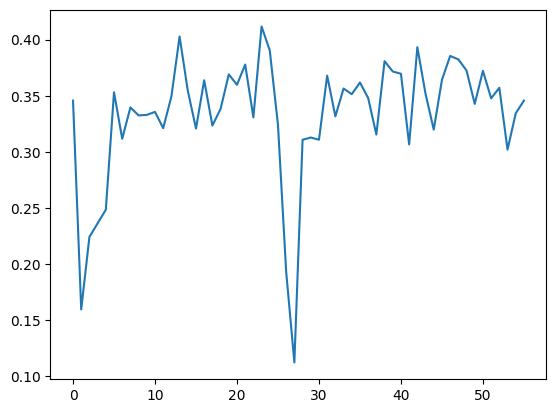

In [44]:
plt.plot(ewc_accs)

### Conclusion and Limits of EWC

After this project, I have a lot more respect for the naive but effective ngram models on my phone. Without significant investments into designing effective solutions specifically those that can run on mobile devices I don't see n-grams going away anytime soon.

Sure we can beat ngrams with enough GPU power, plenty of ram, and SSD storage. But most smartphones in existent today don't have that capability.


#### Limits of EWC
I found that despite having its advantages, Elastic Weight Consolidation (EWC) has its limits. Specifically:
* EWC needs to keep track of each task for which it wants to prevent "catastrophic forgetting"
* Consequently, it takes a lot of memory to store the "gradients" that EWC needs to track to figure out which parameters are important.
* Since the amount of memory needed to run EWC is large, it may not be practical to store the gradients on the GPU (as was the case here). This requires moving the gradients tracked by EWC to and from the CPU all the time significantly increasing training time.
* The more tasks EWC has to account for, the slower it gets. I dealt with this problem by limiting the tasks EWC is required to track to the 12 recent ones. However, this just made EWC likely to "catastrophic forgetting" for some of the weights resulting in unreliable performance.

#### Results
As seen by the final plot as produced above, EWC's performance in this setting was not super reliable. Yes, in some cases, it was able to score as high as 40%. With over 1600 words in each target dataset, I don't think this was due to random chance. EWC did learn the right patterns. However, due to technical limitations I imposed on the models as explained above, EWC was only allowed to keep track of up to 12 most recent task sets to maintain reasonable training times. On a smartphone, even just 12 task sets would be too many due to the stringent ram limitations on such devices. Therefore, my theory on what happened is that the "forgetting" of old tasks allowed the wrong weights to be affected causing unreliable performance. I also tried several other variations of hyperparameters with no-better results.

 At least until smartphones become significantly more powerful (and come built in with GPUs) or breakthroughs for CPU training happens. In its current state, the only way something like "NextType" could work is if all typed data is sent to a powerful machine for calculations, and suggestions are streamed back onto the smartphones. Naturally with privacy concerns this is impractical. All in all, at 146MB, the ngrams baseline model was the king, and it seems looking at the challenges that it will stay that way for a while.

### Further exploration:

If more time was available, further extentions of this projects may include:
* Allowing new vocabulary to be learned.
* Trying this experiment with T5 or another model.
* Using custom grammar correction models for better data pre-processing.
* More messing around with hyperparameters.


### Resources and Publications

Special thanks to the following resources and research papers for making this project possible:

1. Tunstall, L., Werra, L., Wolf, T., &amp; Géron, A. (2022). Natural language processing with transformers: Building language applications with hugging face. O’Reilly.

> Repeatedly recommended by both Professor Snyder and other students in CS505, this book helped familiarize me with the hugging face eco-system.

2. "Transformers" Hugging Face, https://huggingface.co/docs/transformers/. Accessed 1 Dec. 2023.

> Various documentation pages on using the Hugging face library were invaluable help!

3. Kirkpatrick, James, et al. “Overcoming Catastrophic Forgetting in Neural Networks.” arXiv.Org, 25 Jan. 2017, arxiv.org/abs/1612.00796.

> The original ground-breaking paper that introduced the Elastic Weight Consolidation (EWC) algorithm used in this project.

4. https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb

> Example notebook by the ContinualAI open source community whose code was adapted to help me my own EWC implementation.

5. https://212digital.medium.com/fine-tuning-the-gpt-2-large-language-model-unlocking-its-full-potential-66e3a082ab9c

> Another resource on Fine-Tuning, this one specifically for GPT2, the model I used in this project.

6. RaiderBDev, et al. “Reddit Comments/Submissions 2005-06 to 2023-09.” https://academictorrents.com/details/89d24ff9d5fbc1efcdaf9d7689d72b7548f699fc

> Neatly organized scrapped data from reddit. This is where the raw data used in this project was extracted from.

7. https://github.com/huggingface/tokenizers/issues/1160

> A GitHub conversation on the hugging face GitHub discussing vocab updating strategies.

8. https://huggingface.co/pszemraj/grammar-synthesis-small

> The grammar correction pipeline used in the project. It uses T5-small on the backend.